## Simulação de Monte Carlo

Nesse notebook é realizada a Simulção de Monte Carlo das emissões evitadas pela eletrificação da frota

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import random
from utils.load_csv import load_csv
from utils.save_csv import save_csv

Dados requisição antiga

In [2]:
gdf = load_csv("gdf_final.csv")
df_diesel = gdf[gdf["is_eletrico"] == False].copy()

In [3]:
def sim_monte_carlo(df_diesel, Y, N=2000, seed=42):
    np.random.seed(seed)
    resultados = []

    for _ in range(N):
        amostra = df_diesel.sample(n=Y, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados.append(emissao_total)

    impacto_medio = np.mean(resultados)
    impacto_maximo = df_diesel.nlargest(Y, "emissao_co2")["emissao_co2"].sum()
    impacto_diferenca = impacto_maximo - impacto_medio
    IC_inf = np.percentile(resultados, 2.5)
    IC_sup = np.percentile(resultados, 97.5)

    return {
        "Y": Y,
        "impacto_medio": impacto_medio,
        "IC_inf": IC_inf,
        "IC_sup": IC_sup,
        "impacto_maximo": impacto_maximo,
        "impacto_diferenca": impacto_diferenca,
        "resultados": resultados
    }

In [4]:
tamanhos_frota = [50, 100, 200]
res = [sim_monte_carlo(df_diesel, y) for y in tamanhos_frota]

In [5]:
tabela_resumo = pd.DataFrame([
    {
        "Tamanho da frota substituída (Y)": r["Y"],
        "Emissão média evitada (t CO₂/dia)": r["impacto_medio"],
        "IC95% inferior": r["IC_inf"],
        "IC95% superior": r["IC_sup"],
        "Cenário máximo (t CO₂/dia)": r["impacto_maximo"],
        "Diferença (Máx - Média)": r["impacto_diferenca"]
    }
    for r in res
])

tabela_resumo = tabela_resumo.round(5)
tabela_resumo = tabela_resumo.sort_values(by="Tamanho da frota substituída (Y)")

print("\nResumo dos resultados da Simulação de Monte Carlo")
print("=" * 90)
display(tabela_resumo)


Resumo dos resultados da Simulação de Monte Carlo


,Tamanho da frota substituída (Y),Emissão média evitada (t CO₂/dia),IC95% inferior,IC95% superior,Cenário máximo (t CO₂/dia),Diferença (Máx - Média)
0,50,0.00813,0.00384,0.02853,1.58028,1.57215
1,100,0.01631,0.00922,0.04323,2.61569,2.59938
2,200,0.03249,0.02062,0.06753,3.93959,3.90710


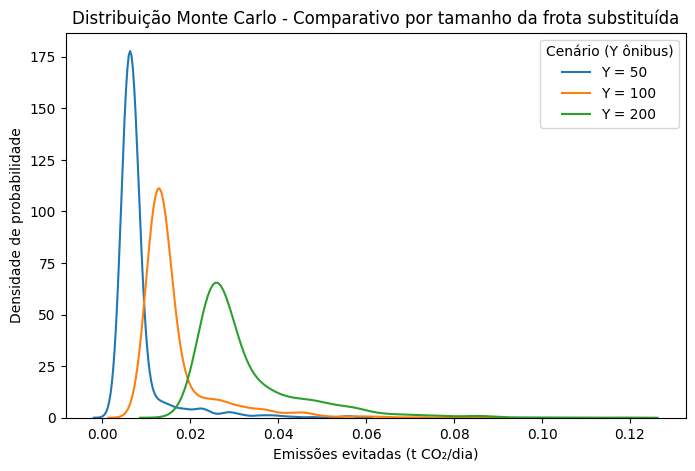

In [6]:
plt.figure(figsize=(8,5))
for r in res:
    sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}")
plt.xlabel("Emissões evitadas (t CO₂/dia)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.show()

Dados de teste do Dagster

In [7]:
df_posicoes_d1 = load_csv("calculo-distancia-percorrida_2025-10-20_silver.csv")
df_posicoes_d2 = load_csv("calculo-distancia-percorrida_2025-10-19_silver.csv")
df_posicoes_d3 = load_csv("calculo-distancia-percorrida_2025-10-17_silver.csv")

In [8]:
df_posicoes = pd.concat([df_posicoes_d1, df_posicoes_d2, df_posicoes_d3], ignore_index=True)

In [9]:
# aleatorização de modelos + ar condicionado
consumo_diesel = load_csv('consumo_diesel.csv')

tipos = consumo_diesel["tecnologia"].tolist()

mapa_modelo = {id_onibus: random.choice(tipos) for id_onibus in df_posicoes['codigo_onibus'].unique()}

df_posicoes['modelo'] = df_posicoes['codigo_onibus'].map(mapa_modelo)

df_posicoes = df_posicoes.merge(consumo_diesel, left_on="modelo", right_on="tecnologia", how="left")

np.random.seed(42)

df_posicoes["tem_ar"] = np.random.choice([True, False], size=len(df_posicoes))

In [10]:
# por codigo_onibus sum(distancia percorrida), pro onibus codigo_onibus x -> distancia_total=sum(distancia)
df_posicoes = (
    df_posicoes
    .groupby("codigo_onibus", as_index=False)
    .agg({
        "codigo_linha": "first",
        "nome_linha": "first",
        "letreiro": "first",
        "distancia_percorrida": "sum",
        "hora_requisicao": "first",
        "x": "first",
        "y": "first",
        "hora_gps": "last",
        "ponto_final": "last",
        "hora_final": "last",
        "segundos_deslocamento": "sum",
        "geometry": "first",
        "modelo": "first",
        "tem_ar": "first",
        'tecnologia': 'first',
        'sem_ar_l_km': 'first',
        'sem_ar_kg_km': 'first',
        'com_ar_l_km': 'first',
        'com_ar_kg_km': 'first' 
    })
)

In [11]:
# consumo -> distancia *modelos, #emissão -> consumo valor_emissao
def get_tipo_onibus(id_onibus):

    onibus = df_posicoes[df_posicoes['codigo_onibus']==id_onibus]

    return onibus['modelo'].unique()[0]


def get_fator_consumo(tipo_veiculo):

    cosumo_modelo = consumo_diesel[consumo_diesel['tecnologia']==tipo_veiculo]

    return cosumo_modelo['com_ar_l_km'].unique()[0]


def get_consumo_co2(row, km_rodados):

    fator_emissao_co2 = 2.671 

    consumo_l_km = row["com_ar_l_km"] if row["tem_ar"] else row["sem_ar_l_km"]

    emissao_co2 = km_rodados * consumo_l_km * fator_emissao_co2
    
    return emissao_co2


for i, row in df_posicoes.iterrows():
    if i < len(df_posicoes)-1:
        df_posicoes.loc[i, 'emissao_co2'] = get_consumo_co2(row, row['distancia_percorrida'])

df_posicoes["emissao_co2"] = df_posicoes["emissao_co2"] / 1000 # toneladas

In [12]:
def sim_monte_carlo(df_posicoes, Y, N=2000, seed=42):
    np.random.seed(seed)
    resultados = []

    for _ in range(N):
        amostra = df_posicoes.sample(n=Y, replace=False)
        emissao_total = amostra["emissao_co2"].sum()
        resultados.append(emissao_total)

    impacto_medio = np.mean(resultados)
    impacto_maximo = df_posicoes.nlargest(Y, "emissao_co2")["emissao_co2"].sum()
    impacto_diferenca = impacto_maximo - impacto_medio
    IC_inf = np.percentile(resultados, 2.5)
    IC_sup = np.percentile(resultados, 97.5)

    return {
        "Y": Y,
        "impacto_medio": impacto_medio,
        "IC_inf": IC_inf,
        "IC_sup": IC_sup,
        "impacto_maximo": impacto_maximo,
        "impacto_diferenca": impacto_diferenca,
        "resultados": resultados
    }

In [13]:
tamanhos_frota = [50, 100, 200]
res = [sim_monte_carlo(df_posicoes, y) for y in tamanhos_frota]

In [14]:
tabela_resumo = pd.DataFrame([
    {
        "Tamanho da frota substituída (Y)": r["Y"],
        "Emissão média evitada (t CO₂/no período)": r["impacto_medio"],
        "IC95% inferior": r["IC_inf"],
        "IC95% superior": r["IC_sup"],
        "Cenário máximo (t CO₂/no período)": r["impacto_maximo"],
        "Diferença (Máx - Média)": r["impacto_diferenca"]
    }
    for r in res
])

tabela_resumo = tabela_resumo.round(5)
tabela_resumo = tabela_resumo.sort_values(by="Tamanho da frota substituída (Y)")

print("\nResumo dos resultados da Simulação de Monte Carlo")
print("=" * 90)
display(tabela_resumo)


Resumo dos resultados da Simulação de Monte Carlo


,Tamanho da frota substituída (Y),Emissão média evitada (t CO₂/no período),IC95% inferior,IC95% superior,Cenário máximo (t CO₂/no período),Diferença (Máx - Média)
0,50,41742.11535,34925.11665,49949.91191,216638.87425,174896.75891
1,100,83359.50461,73277.82575,94728.34880,357499.66811,274140.16350
2,200,166794.39378,152921.71990,184227.62648,600583.61166,433789.21788


In [15]:
#plt.figure(figsize=(8,5))
#for r in res:
    #sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}")
#plt.xlabel("Emissões evitadas (t CO₂/no período)")
#plt.ylabel("Densidade de probabilidade")
#plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
#plt.legend(title="Cenário (Y ônibus)")
#plt.show()

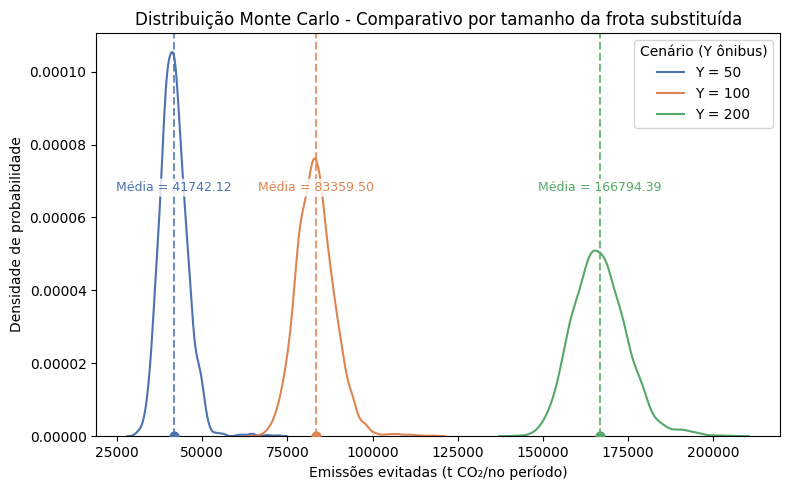

In [16]:
plt.figure(figsize=(8,5))

cores = sns.color_palette("deep", len(res))

for i, r in enumerate(res):
    sns.kdeplot(r["resultados"], label=f"Y = {r['Y']}", color=cores[i])
    
    media = np.mean(r["resultados"])
    
    plt.axvline(media, linestyle='--', color=cores[i], alpha=0.8)
    
    plt.scatter(media, 0, color=cores[i], s=40, zorder=5)
    
    plt.text(media, plt.ylim()[1]*0.6,  
             f"Média = {media:.2f}",  
             ha='center', va='bottom', color=cores[i],
             fontsize=9, rotation=0,
             bbox=dict(facecolor='white', alpha=0.8, edgecolor='none', boxstyle='round,pad=0.2'))

plt.xlabel("Emissões evitadas (t CO₂/no período)")
plt.ylabel("Densidade de probabilidade")
plt.title("Distribuição Monte Carlo - Comparativo por tamanho da frota substituída")
plt.legend(title="Cenário (Y ônibus)")
plt.tight_layout()
plt.show()


In [17]:
df_posicoes["hora_gps"] = pd.to_datetime(df_posicoes["hora_gps"])

df_posicoes = df_posicoes.sort_values("hora_gps").reset_index(drop=True)

dias_unicos = df_posicoes["hora_gps"].dt.date.unique()
mapa_dias = {d: f"dia {i+1}" for i, d in enumerate(dias_unicos)}
df_posicoes["dia"] = df_posicoes["hora_gps"].dt.date.map(mapa_dias)

In [18]:
save_csv(df_posicoes, "df_posicoes_dagster.csv")

Base salva em data\df_posicoes_dagster.csv
